# Predicting Survival on the Titanic: An Iterative Analysis

This notebook presents a detailed analysis of the classic Titanic dataset. The primary objective is to build a predictive model that can determine the likelihood of survival for a passenger on the RMS Titanic, the British ocean liner that sank on April 15, 1912.

My approach is centered on iterative refinement. Through multiple cycles of feature engineering and model evaluation, I will explore various strategies to enhance the dataset and improve predictive accuracy. This process is designed to demonstrate how different analytical choices can lead to a more robust and insightful solution.

For this project, the focus will be exclusively on classical machine learning algorithms. Due to hardware limitations, deep learning models will not be explored, allowing us to concentrate on the effectiveness and interpretability of traditional methods.

## Importing Libraries and Necessary Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import LinearSVC

In [2]:
def load_df(df_name, parse_date=False, date_cols=[]) -> pd.DataFrame:
    """
    This function reads the .csv file and load it as a Pandas' dataframe.

    :param str df_name: the name of the file complete with directory.
    :param str parse_date: a boolean to see if parsing date is needed. Set False by default.
    :param list date_cols: a list of string that will be referred when date parsing is needed.
    Set as an empty list by default.

    :return: A dataframe.
    :rtype: DataFrame
    """

    if parse_date:
        return pd.read_csv(df_name, parse_date=date_cols)
    return pd.read_csv(df_name)

In [3]:
def skim_data(data) -> pd.DataFrame:
    """
    Skims the dataframe for features, feature types, null, negative, and zero values
    percentage, and the number of unique values.

    :param DataFrame data: The input dataframe.
    :return: A dataframe contains the summary of the input dataframe.
    :rtype: DataFrame
    """

    numeric_cols = set(data.select_dtypes(include=[np.number]).columns)
    numeric_stats = {}
    for col in numeric_cols:
        numeric_stats[col] = {
            'neg_%': round((data[col] < 0).mean() * 100, 3),
            'zero_%': round((data[col] == 0).mean() * 100, 3)
        }

    skimmed_data = pd.DataFrame({
        'feature': data.columns.values,
        'dtype': data.dtypes.astype(str).values,
        'null_%': round(data.isna().mean() * 100, 3).values,
        'negative_%': [numeric_stats.get(col, {}).get('neg_%', '-') for col in data.columns],
        'zero_%': [numeric_stats.get(col, {}).get('zero_%', '-') for col in data.columns],
        'n_unique': data.nunique().values,
        'unique_%': round(data.nunique() / len(data) * 100, 2).values,
        'sample_values': [list(data[col].dropna().unique()[:5]) for col in data.columns]
    })

    print(f'Total duplicate rows: {data.duplicated().sum()}')
    print(f'DF shape: {data.shape}')

    return skimmed_data

In [4]:
def title_extractor(df, col='Name', dest_col='Title') -> pd.DataFrame:
    """
    Extracts, cleans, and standardizes titles from a certain column and 
    put it in the destination column.

    :param DataFrame df: The input dataframe
    :param str col: A target column. Use 'Name' as the default
    :param str dest_col: A destination column. Use 'Title` as the default

    :return: the dataframe with added values.
    :rtype: DataFrame
    """

    def clean_title(title):
        """A helper function to group titles."""
        if title in ['Ms', 'Mlle']:
            return 'Miss'
        if title in ['Mme']:
            return 'Mrs'
        return title

    """
    using `**` to tell Python to take the key-value pairs from the dict and
    treat them as if they were keyword=value arguments
    """
    return (
        df
        .assign(
            **{
                dest_col: lambda x: (
                    x[col]
                    .str.extract(r' ([A-Za-z]+)\.', expand=False)
                    .apply(clean_title)
                )
            }
        )
        .assign(
            **{
                dest_col: lambda x: (
                    x[dest_col].replace(
                        (counts := x[dest_col].value_counts())[counts < counts.get('Master', 0)].index,
                        'Rare'
                    )
                )
            }
        )
    )

In [5]:
def feature_imputation(df, col, method='median', based_col=None) -> pd.DataFrame:
    """
    Imputes missing values in a column using a specified method, optionally grouped by another column.

    This function operates on a copy of the DataFrame and does not modify the original.

    :param pd.DataFrame df: The input pandas DataFrame.
    :param str col: The name of the column to impute (the target column).
    :param str method: The imputation method to use. Must be 'mean' or 'median'. Defaults to 'median'.
    :param str based_col: Optional. The name of the column to group by for imputation.
                          If provided, the calculation (mean/median) is performed for each
                          unique group within this column. If not provided, a global
                          imputation is performed.

    :raises ValueError: If the method is not 'mean' or 'median'.
    :raises KeyError: If the specified columns do not exist in the DataFrame.

    :return: A new DataFrame with the specified column imputed.
    :rtype: pd.DataFrame
    
    :example:

    >>> # Global imputation
    >>> imputed_df = feature_imputation(df, col='Age', method='median')

    >>> # Grouped imputation (impute Age based on the median age of each Title)
    >>> imputed_df = feature_imputation(df, col='Age', method='median', based_col='Title')
    """
    
    if method not in ['mean', 'median']:
        raise ValueError('Method must be either "mean" or "median"')
    if col not in df.columns:
        raise KeyError(f'Column {col} not found in the dataframe')
    if based_col and based_col not in df.columns:
        raise KeyError(f'Grouping column {based_col} not found in the dataframe')
    
    df_imputed = df.copy()
    
    if based_col:
        values = df_imputed.groupby(based_col)[col].transform(method)
        df_imputed[col] = df_imputed[col].fillna(values)
    else:
        value = df_imputed[col].agg(method)
        df_imputed[col] = df_imputed[col].fillna(value)
    return df_imputed

## Load Dataset

In [6]:
df_train = load_df('input/train.csv')

display(df_train)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [7]:
df_test = load_df('input/test.csv')

display(df_test)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Data Wrangling and Exploratory Data Analysis

Let's begin with an initial inspection of the training data.

In [8]:
skim_data(df_train)

Total duplicate rows: 0
DF shape: (891, 12)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,19.865,0.0,0.0,88,9.88,"[22.0, 38.0, 26.0, 35.0, 54.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


Based on this first look, the dataset appears to be in good shape. There are no obvious errors like negative values in numerical columns or placeholder text in object-type features. However, a few key points require attention:

*   The `Name` column contains titles and salutations (e.g., Mr., Mrs., Capt.), which could be a valuable source of information.
*   The `Age` and `Cabin` columns have a significant number of null values that will need to be addressed.
*   A very small percentage of data is missing from the `Embarked` column.

To ensure the integrity of the original data throughout the cleaning process, I will work with a copy of the training dataframe.

In [9]:
df_train_copy = df_train.copy()

### Call Me By Your `Name`

This section is inspired by the excellent work of [Megan L. Risdal](https://www.kaggle.com/code/mrisdal/exploring-survival-on-the-titanic/report) and [Aldemuro M. A. Haris](https://www.kaggle.com/code/aldemuro/comparing-ml-algorithms-train-accuracy-90/notebook). Their analyses highlighted that a passenger's title can be a strong proxy for social status, which may correlate with survival. This same logic might apply to the `Cabin` feature, which we will explore later.

First, let's extract these titles from the `Name` column.

In [10]:
df_temp = (
    df_train_copy
    .assign(
        Title=lambda x: x['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    )
)

display(df_temp.head())
display(df_temp['Title'].unique())
display(skim_data(df_temp))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

Total duplicate rows: 0
DF shape: (891, 13)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,19.865,0.0,0.0,88,9.88,"[22.0, 38.0, 26.0, 35.0, 54.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


The extraction yields 17 unique titles. Let's examine their distribution.

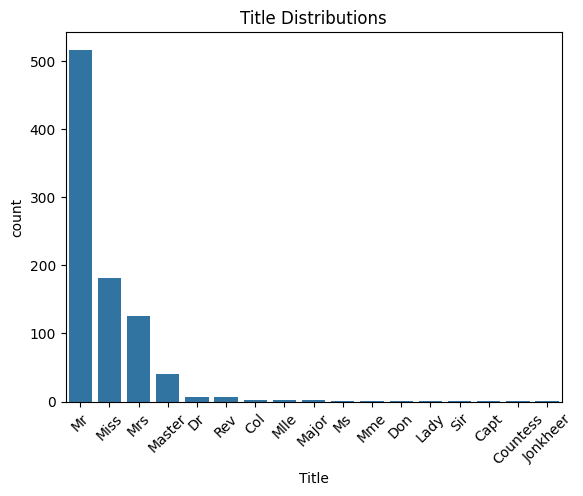

In [11]:
sns.countplot(data=df_temp, x='Title', order=df_temp['Title'].value_counts().index)
plt.title('Title Distributions')
plt.xticks(rotation=45)
plt.show()

The distribution shows a steep drop-off in frequency after the first few common titles. I'll use the count of `Master` as a threshold; any title less frequent will be consolidated into a single 'Rare' category. This approach simplifies the feature while retaining the information from the most common titles.

Before grouping, I will consolidate some similar titles. `Ms` is a variant of `Miss`, while `Mme` (Madame) and `Mlle` (Mademoiselle) are French equivalents of `Mrs` and `Miss`, respectively. These will be mapped to their common English counterparts to standardize the feature.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Total duplicate rows: 0
DF shape: (891, 13)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,19.865,0.0,0.0,88,9.88,"[22.0, 38.0, 26.0, 35.0, 54.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


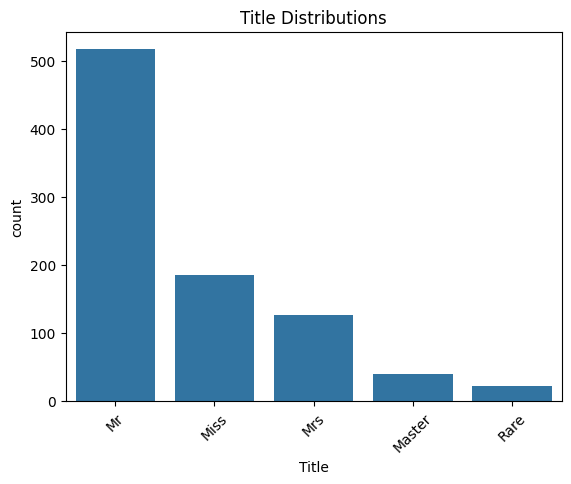

In [12]:
df_train_copy = title_extractor(df_train_copy)

display(df_train_copy.head())
display(skim_data(df_train_copy))

sns.countplot(data=df_train_copy, x='Title', order=df_train_copy['Title'].value_counts().index)
plt.title('Title Distributions')
plt.xticks(rotation=45)
plt.show()

This process has cleaned and simplified the `Title` feature, making it more suitable for modeling.

### What's my `Age` again?

A well-known historical maritime protocol was the "women and children first" rule, also known as the Birkenhead Drill. This forms the basis of my hypothesis that `Age` is a critical feature for predicting survival.

With nearly 20% of `Age` values missing, imputation is necessary. A simple approach would be to use the mean or median of the entire dataset, but this would be too general. A more nuanced strategy, also seen in Aldemuro's work, is to impute `Age` based on the median value for each passenger's `Title` group.

To decide between the mean and median, we can visualize the age distribution for each title.

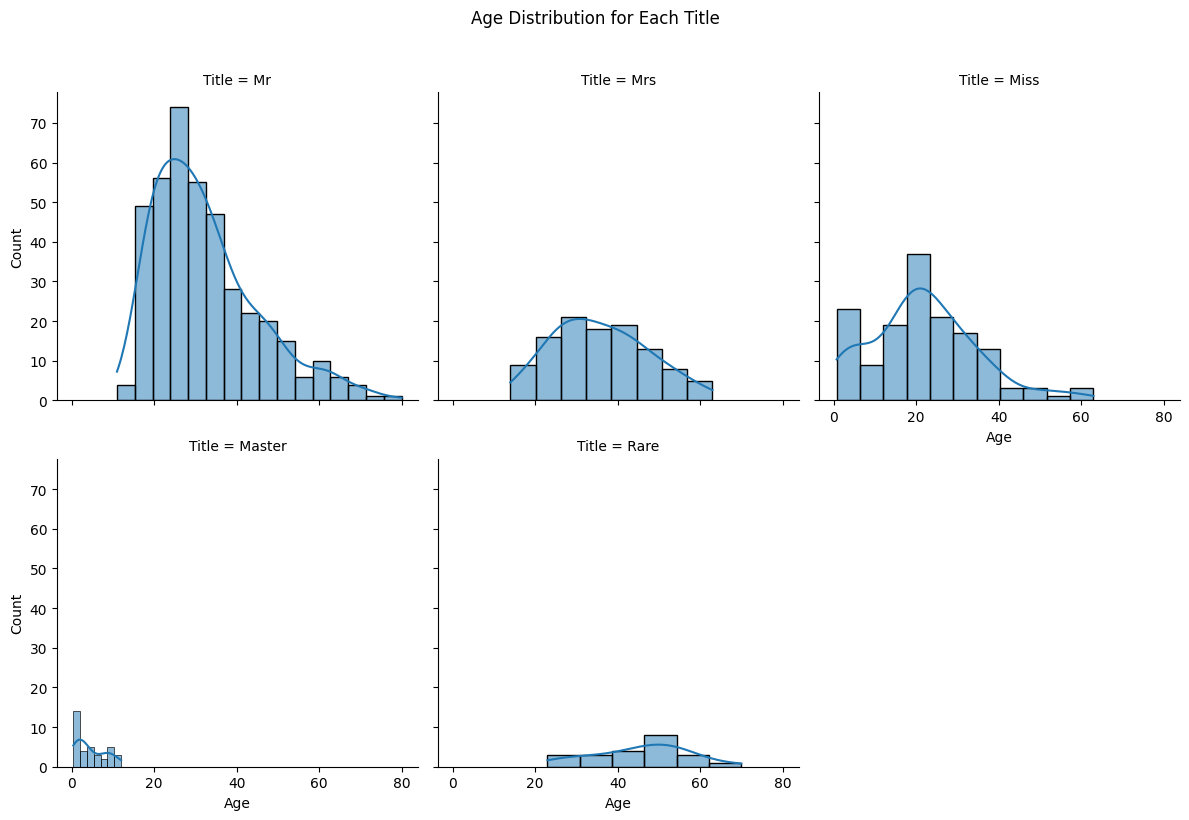

In [13]:
fg = sns.FacetGrid(df_train_copy, col='Title', col_wrap=3, height=4)
fg.map(sns.histplot, 'Age', kde=True)
fg.figure.suptitle('Age Distribution for Each Title', y=1.02)
plt.tight_layout()
plt.show()

The boxplots reveal that the age distributions within most title groups are skewed. Therefore, the *median* is a more robust measure of central tendency than the mean and is the better choice for imputation.

In [14]:
df_train_copy = feature_imputation(df_train_copy, col='Age', based_col='Title')

In [15]:
display(skim_data(df_train_copy))

Total duplicate rows: 0
DF shape: (891, 13)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,0.000,0.0,0.0,90,10.10,"[22.0, 38.0, 26.0, 35.0, 30.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


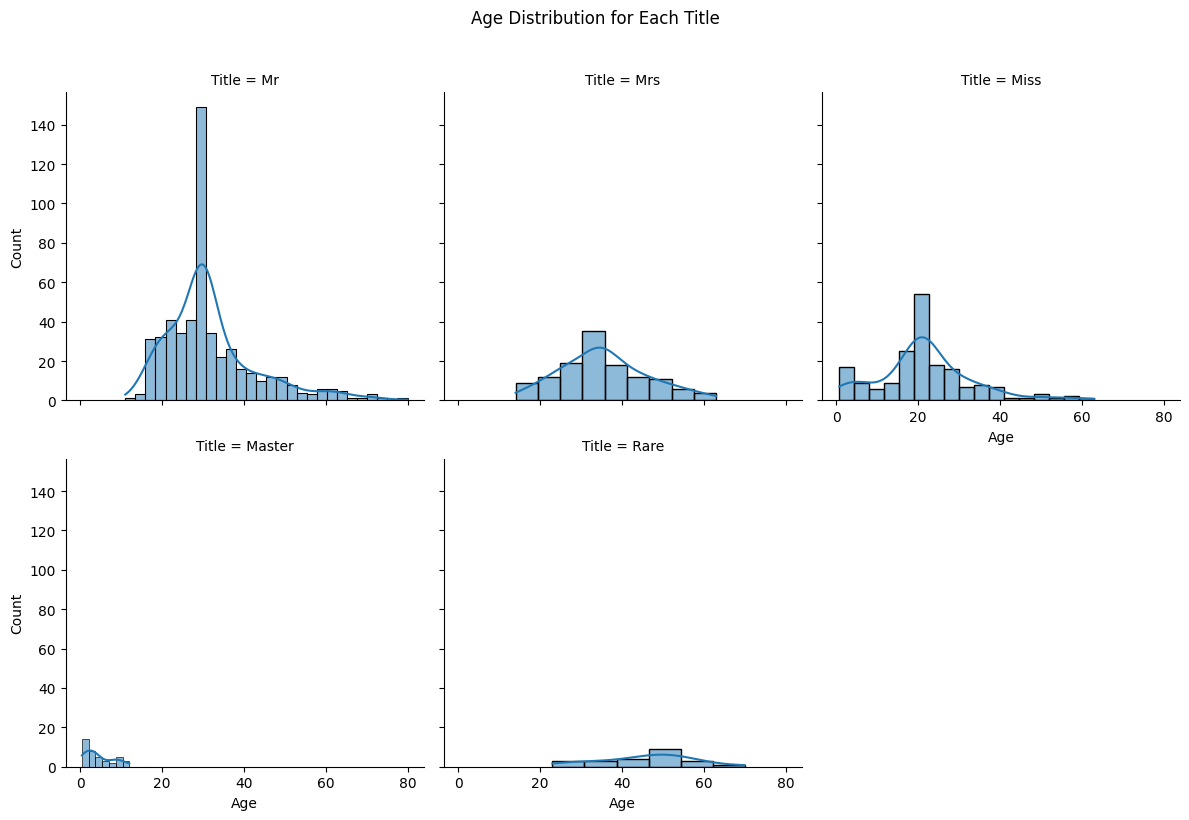

In [16]:
fg = sns.FacetGrid(df_train_copy, col='Title', col_wrap=3, height=4)
fg.map(sns.histplot, 'Age', kde=True)
fg.fig.suptitle('Age Distribution for Each Title', y=1.02)
plt.tight_layout()
plt.show()

With the missing `Age` values now intelligently filled, we can move to the next feature.

### Little `Cabin` on the Prairie

The Titanic was divided into seven decks, with First Class occupying the upper decks (A, B, and C) and other classes on the lower decks. Passengers on upper decks likely had faster and easier access to lifeboats, especially as the ship sank bow-first.

The `Cabin` feature is missing nearly 70% of its values. Rather than discarding it, we can hypothesize that the most important information is not the specific cabin number, but whether a passenger had a recorded cabin at all. The presence of a cabin number likely correlates strongly with being a First Class passenger.

Let's create a new binary feature, `HasCabin`, to capture this information.

In [17]:
df_train_copy = (
    df_train_copy
    .assign(
        HasCabin=lambda x: x['Cabin'].notna().astype(int)
    )
)

display(df_train_copy.sample(10, random_state=39))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasCabin
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,Mr,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,1
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S,Mr,1
197,198,0,3,"Olsen, Mr. Karl Siegwart Andreas",male,42.0,0,1,4579,8.4042,NaN,S,Mr,0
462,463,0,1,"Gee, Mr. Arthur H",male,47.0,0,0,111320,38.5000,E63,S,Mr,1
620,621,0,3,"Yasbeck, Mr. Antoni",male,27.0,1,0,2659,14.4542,NaN,C,Mr,0
847,848,0,3,"Markoff, Mr. Marin",male,35.0,0,0,349213,7.8958,NaN,C,Mr,0
575,576,0,3,"Patchett, Mr. George",male,19.0,0,0,358585,14.5000,NaN,S,Mr,0
436,437,0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.3750,NaN,S,Miss,0
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,Master,0


Now, let's examine the relationship between this new feature and survival.

/var/folders/34/_j3kcpxd38lfbdvtp0clnhrw0000gn/T/ipykernel_83675/3405284920.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['No', 'Yes'])


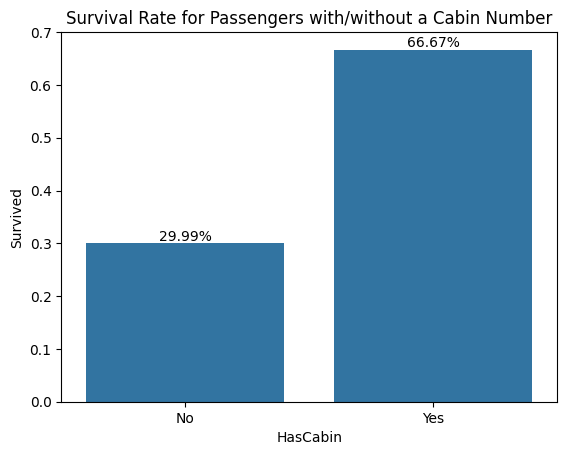

In [18]:
ax = sns.barplot(data=df_train_copy, x='HasCabin', y='Survived', errorbar=None)
ax.bar_label(ax.containers[0], fmt='{:.2%}')
ax.set_xticklabels(['No', 'Yes'])
ax.set_title('Survival Rate for Passengers with/without a Cabin Number')
plt.show()

The result is striking: over 66% of passengers with a recorded cabin survived, compared to just 30% of those without. This confirms that `HasCabin` is a potentially powerful predictive feature.

### Much Ado About Nothing

Let's review the state of our dataset after these transformations.

In [19]:
skim_data(df_train_copy)

Total duplicate rows: 0
DF shape: (891, 14)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,0.000,0.0,0.0,90,10.10,"[22.0, 38.0, 26.0, 35.0, 30.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


The dataset is almost clean. The only remaining missing values are two entries (0.2%) in the `Embarked` column. Let's examine the distribution of this feature.

In [20]:
(
    df_train_copy
    .loc[lambda x: x['Embarked'].isna()]
)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasCabin
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,1


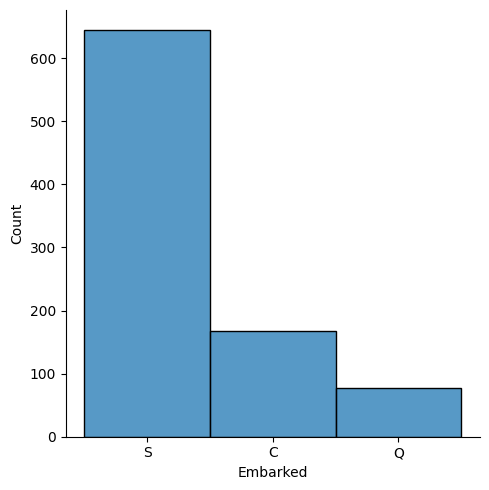

In [21]:
sns.displot(
    df_train_copy, x='Embarked', binwidth=3,
    facet_kws=dict(margin_titles=True)
)

The overwhelming majority of passengers embarked at Southampton (`S`). Given this distribution, it is reasonable to fill the two missing values with the mode, `S`.

In [22]:
df_train_copy = (
    df_train_copy
    .assign(
        Embarked=lambda x: x['Embarked'].fillna('S')
    )
)

In [23]:
skim_data(df_train_copy)

Total duplicate rows: 0
DF shape: (891, 14)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,int64,0.000,0.0,0.0,3,0.34,"[3, 1, 2]"
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,0.000,0.0,0.0,90,10.10,"[22.0, 38.0, 26.0, 35.0, 30.0]"
6,SibSp,int64,0.000,0.0,68.238,7,0.79,"[1, 0, 3, 4, 2]"
7,Parch,int64,0.000,0.0,76.094,7,0.79,"[0, 1, 2, 5, 3]"
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,0.0,1.684,248,27.83,"[7.25, 71.2833, 7.925, 53.1, 8.05]"


With the data now fully cleaned and new features engineered, we are ready to proceed to the modeling phase.

## Modeling and Prediction

With a clean and engineered dataset, we can now proceed to the modeling phase.

Selecting the right algorithm is a key step. The [scikit-learn algorithm flowchart](https://scikit-learn.org/stable/machine_learning_map.html) provides an excellent, practical guide for this process. Following its recommendations for a classification task with our dataset's characteristics, I have selected **Linear Support Vector Classifier (LinearSVC)** as the initial estimator.

LinearSVC is a classification algorithm that works by finding an optimal hyperplane that best separates the different classes in the feature space. This hyperplane is positioned to be as far as possible from the nearest data points of any class (the "support vectors"). To work effectively, LinearSVC requires the input data to meet a few conditions:

*   All missing values must be handled.
*   All categorical features must be converted to a numerical format.
*   Numerical features should be scaled to a common range.

Our work in the previous section has already addressed the missing data, so we can proceed with the next two steps.

### Encoding Categorical Features

First, let's identify the categorical and numerical features in our processed dataset.

In [24]:
cat_cols = ['Sex', 'Embarked', 'Title']
num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
binary_cols = ['HasCabin']

To convert the categorical features into a numerical format suitable for a linear model, I will use **One-Hot Encoding (OHE)**. This technique creates new binary (0 or 1) columns for each category within a feature. For example, the `Embarked` feature, with its categories `S`, `C`, and `Q`, will be transformed into three new columns: `Embarked_S`, `Embarked_C`, and `Embarked_Q`.

This method is preferable to simple label encoding (e.g., S=1, C=2, Q=2) for linear models. Label encoding can introduce a false and meaningless ordinal relationship (e.g., `S` < `C` < `Q`), which the model might misinterpret. OHE avoids this by representing each category independently.

Let's implement this using `sklearn.preprocessing`.

In [25]:
df_temp = df_train_copy.copy()

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe_train_features = ohe.fit_transform(df_temp[cat_cols])
ohe_train_df = pd.DataFrame(ohe_train_features, index=df_temp.index, columns=ohe.get_feature_names_out())

display(ohe_train_features)
display(ohe.get_feature_names_out())

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]], shape=(891, 10))

array(['Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Rare'], dtype=object)

In [26]:
display(ohe_train_df)
display(skim_data(ohe_train_df))

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
886,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
887,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
888,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
889,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Total duplicate rows: 874
DF shape: (891, 10)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,Sex_female,float64,0.0,0.0,64.759,2,0.22,"[0.0, 1.0]"
1,Sex_male,float64,0.0,0.0,35.241,2,0.22,"[1.0, 0.0]"
2,Embarked_C,float64,0.0,0.0,81.145,2,0.22,"[0.0, 1.0]"
3,Embarked_Q,float64,0.0,0.0,91.358,2,0.22,"[0.0, 1.0]"
4,Embarked_S,float64,0.0,0.0,27.497,2,0.22,"[1.0, 0.0]"
5,Title_Master,float64,0.0,0.0,95.511,2,0.22,"[0.0, 1.0]"
6,Title_Miss,float64,0.0,0.0,79.237,2,0.22,"[0.0, 1.0]"
7,Title_Mr,float64,0.0,0.0,41.975,2,0.22,"[1.0, 0.0]"
8,Title_Mrs,float64,0.0,0.0,85.859,2,0.22,"[0.0, 1.0]"
9,Title_Rare,float64,0.0,0.0,97.419,2,0.22,"[0.0, 1.0]"


The OHE process has been applied successfully. Next, we will turn our attention to the numerical features.

### Scaling Numerical Features

Feature scaling is critical for distance-based algorithms like SVMs. The algorithm's objective is to maximize the margin between classes, a calculation that relies on the Euclidean distance between data points. If features are on vastly different scales, the feature with the larger scale can unfairly dominate this calculation.

Consider `Age` (ranging from ~0 to 80) and `Fare` (ranging from ~0 to over 500). Let's take two passengers:

*   **Passenger X:** Age = 20, Fare = 10
*   **Passenger Y:** Age = 40, Fare = 310

The squared Euclidean distance is `(20 - 40)² + (10 - 310)² = 400 + 90,000 = 90,400`. The contribution from the `Fare` difference (90,000) completely overshadows the contribution from the `Age` difference (400).

By applying a scaler like **StandardScaler**, we transform each feature to have a mean of 0 and a standard deviation of 1. With hypothetical scaled values, the calculation might look like this:

*   **Passenger X:** Age = -0.8, Fare = -0.4
*   **Passenger Y:** Age = 0.7, Fare = 2.5

The new distance is `(-0.8 - 0.7)² + (-0.4 - 2.5)² = 2.25 + 8.41 = 10.66`. Now, both features contribute to the distance calculation on a comparable scale, allowing the algorithm to learn their true relationships.

In [27]:
df_numerical_scaler = df_train_copy.copy()
scaler = StandardScaler()
df_numerical_scaler[num_cols] = scaler.fit_transform(df_numerical_scaler[num_cols])

display(df_numerical_scaler.head())
display(skim_data(df_numerical_scaler))
display(df_numerical_scaler[num_cols].describe())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,HasCabin
0,1,0,0.827377,"Braund, Mr. Owen Harris",male,-0.557460,0.432793,-0.473674,A/5 21171,-0.502445,NaN,S,Mr,0
1,2,1,-1.566107,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,0.649091,0.432793,-0.473674,PC 17599,0.786845,C85,C,Mrs,1
2,3,1,0.827377,"Heikkinen, Miss. Laina",female,-0.255822,-0.474545,-0.473674,STON/O2. 3101282,-0.488854,NaN,S,Miss,0
3,4,1,-1.566107,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,0.422862,0.432793,-0.473674,113803,0.420730,C123,S,Mrs,1
4,5,0,0.827377,"Allen, Mr. William Henry",male,0.422862,-0.474545,-0.473674,373450,-0.486337,NaN,S,Mr,0


Total duplicate rows: 0
DF shape: (891, 14)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,PassengerId,int64,0.000,0.0,0.0,891,100.00,"[1, 2, 3, 4, 5]"
1,Survived,int64,0.000,0.0,61.616,2,0.22,"[0, 1]"
2,Pclass,float64,0.000,44.893,0.0,3,0.34,"[0.8273772438659699, -1.5661069258891576, -0.3..."
3,Name,object,0.000,-,-,891,100.00,"[Braund, Mr. Owen Harris, Cumings, Mrs. John B..."
4,Sex,object,0.000,-,-,2,0.22,"[male, female]"
5,Age,float64,0.000,47.587,0.0,90,10.10,"[-0.5574601720312115, 0.6490906666288329, -0.2..."
6,SibSp,float64,0.000,68.238,0.0,7,0.79,"[0.4327933656785018, -0.47454519624983954, 2.2..."
7,Parch,float64,0.000,76.094,0.0,7,0.79,"[-0.4736736092984604, 0.7676298785983874, 2.00..."
8,Ticket,object,0.000,-,-,681,76.43,"[A/5 21171, PC 17599, STON/O2. 3101282, 113803..."
9,Fare,float64,0.000,76.319,0.0,248,27.83,"[-0.5024451714361923, 0.7868452935884461, -0.4..."


,Pclass,Age,SibSp,Parch,Fare
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-8.772133e-17,2.232906e-16,4.386066e-17,5.382900e-17,3.987333e-18
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-1.566107e+00,-2.184796e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01
25%,-3.693648e-01,-6.328696e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01
50%,8.273772e-01,4.581525e-02,-4.745452e-01,-4.736736e-01,-3.573909e-01
75%,8.273772e-01,4.228624e-01,4.327934e-01,-4.736736e-01,-2.424635e-02
max,8.273772e-01,3.816287e+00,6.784163e+00,6.974147e+00,9.667167e+00


As shown, the standard deviation of each numerical feature is now 1. We can now combine these scaled numerical features with our one-hot encoded categorical features to create the final dataset for training.

In [28]:
df_temp = (
    pd.concat([df_numerical_scaler[num_cols], ohe_train_df, df_train_copy['HasCabin']], axis=1)
)

display(df_temp.head())

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,HasCabin
0,0.827377,-0.557460,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.566107,0.649091,0.432793,-0.473674,0.786845,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,0.827377,-0.255822,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0
3,-1.566107,0.422862,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
4,0.827377,0.422862,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


Our final feature set is complete, containing a total of 15 features ready for the LinearSVC model.

Let's quickly summarize the full preprocessing pipeline:

-   Extracted `Title` from the `Name` feature.
-   Imputed missing values in `Age` using title-based medians.
-   Imputed missing values in `Embarked` using the mode.
-   Created a binary `HasCabin` feature from the `Cabin` column.
-   Applied One-Hot Encoding to all categorical features.
-   Applied Standard Scaling to all numerical features.
-   Combined these processed features into a final DataFrame.

### Training and Initial Results

We can now initialize and train the LinearSVC model. `random_state` is set for reproducibility and `max_iter` is increased to ensure convergence.

In [29]:
model = LinearSVC(dual='auto', random_state=23, max_iter=5000)

The full preprocessing pipeline is applied before fitting the model.

In [30]:
def preprocess_train(df_input: pd.DataFrame) -> pd.DataFrame:
    df_copy = df_input.copy()
    df_copy = title_extractor(df_copy)

    df_copy = feature_imputation(df_copy, col='Age', based_col='Title')

    df_copy = (
        df_copy
        .assign(
            HasCabin=lambda x: x['Cabin'].notna().astype(int)
        )
    )

    mode_embarked = df_input['Embarked'].mode()[0]
    df_copy['Embarked'] = df_copy['Embarked'].fillna(mode_embarked)

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_features = ohe.fit_transform(df_copy[cat_cols])
    df_ohe = pd.DataFrame(ohe_features, index=df_input.index, columns=ohe.get_feature_names_out())

    scaler = StandardScaler()
    df_copy[num_cols] = scaler.fit_transform(df_copy[num_cols])

    return (
        pd.concat(
            [
                df_copy[num_cols], 
                df_ohe, 
                df_copy['HasCabin']
            ], 
            axis=1
        )
    )

In [31]:
X_train = preprocess_train(df_train.drop('Survived', axis=1))
y_train = df_train['Survived']

In [34]:
model.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,23


In [35]:
def preprocess_test(df_input: pd.DataFrame) -> pd.DataFrame:
    df_copy = df_input.copy()
    df_copy = title_extractor(df_copy)

    median_age = df_train['Age'].median()
    df_copy['Age'] = df_copy['Age'].fillna(median_age)

    df_copy = (
        df_copy
        .assign(
            HasCabin=lambda x: x['Cabin'].notna().astype(int)
        )
    )

    median_fare = df_train['Fare'].median()
    df_copy['Fare'] = df_copy['Fare'].fillna(median_fare)

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe_test_features = ohe.fit_transform(df_copy[cat_cols])
    ohe_test_df = pd.DataFrame(ohe_test_features, index=df_test.index, columns=ohe.get_feature_names_out())

    scaler = StandardScaler()
    df_copy[num_cols] = scaler.fit_transform(df_copy[num_cols])

    return (
        pd.concat(
            [
                df_copy[num_cols], 
                ohe_test_df,
                df_copy['HasCabin']
            ],
            axis=1
        )
    )

df_test_processed = preprocess_test(df_test)

In [36]:
skim_data(df_test_processed)

Total duplicate rows: 34
DF shape: (418, 16)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,Pclass,float64,0.0,47.847,0.000,3,0.72,"[0.873481905063612, -0.3158191904301659, -1.50..."
1,Age,float64,0.0,64.833,0.000,79,18.90,"[0.3710620117837841, 1.358985075004305, 2.5444..."
2,SibSp,float64,0.0,67.703,0.000,7,1.67,"[-0.49947001653571804, 0.6169923733676517, 1.7..."
3,Parch,float64,0.0,77.512,0.000,8,1.91,"[-0.40024770163856355, 0.6198958305865556, 2.6..."
4,Fare,float64,0.0,76.794,0.000,169,40.43,"[-0.49741333194918286, -0.5122780073786185, -0..."
5,Sex_female,float64,0.0,0.000,63.636,2,0.48,"[0.0, 1.0]"
6,Sex_male,float64,0.0,0.000,36.364,2,0.48,"[1.0, 0.0]"
7,Embarked_C,float64,0.0,0.000,75.598,2,0.48,"[0.0, 1.0]"
8,Embarked_Q,float64,0.0,0.000,88.995,2,0.48,"[1.0, 0.0]"
9,Embarked_S,float64,0.0,0.000,35.407,2,0.48,"[0.0, 1.0]"


In [43]:
import time
from joblib import dump

y_pred = model.predict(df_test_processed)
pass_id = df_test['PassengerId']
current_unix_timestamp = time.time()
df_result = pd.DataFrame({'PassengerId': pass_id, 'Survived': y_pred})
df_result.to_csv(f'input/submission_{current_unix_timestamp}.csv', index=False)

# use joblib to store model
_ = dump(model, f'models/model_{current_unix_timestamp}.joblib')

After submitting the predictions from the test set to Kaggle, this initial model achieved a score of **0.77033**. This is a very encouraging result for a first submission without any hyperparameter tuning or more complex ensemble methods.

## Conclusion and Future Work

This notebook successfully established a complete data preprocessing and modeling pipeline, yielding a solid baseline score. The journey, however, is just beginning. To improve upon this result and gain deeper insights, the following steps are planned for the next iteration:

-   **Deeper Performance Analysis:** Move beyond accuracy by evaluating the model with a confusion matrix, precision, recall, and F1-score.
-   **Feature Importance:** Inspect the model's coefficients to understand which features were most influential in its predictions.
-   **Manual Error Analysis:** Investigate specific instances where the model made incorrect predictions to identify patterns and potential areas for feature engineering.

Thank you for following along. I look forward to exploring these areas and further refining this model in the next notebook.